# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [2]:
# Load pickled data
import tensorflow as tf
import math
import cv2
import pickle
import os
import time
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# TODO: fill this in based on where you saved the training and testing data

## The pickles have been converted into python2.x formats 
data_path=os.getcwd()+"/traffic-signs-data"
training_file = data_path+"/train.p"
testing_file = data_path+"/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape =X_train.shape[1:3]

# TODO: how many classes are in the dataset
n_classes = max(y_train)+1

n_channel = X_train.shape[3]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of channels =", n_channel)
print("Number of classes =", n_classes)

('Number of training examples =', 39209)
('Number of testing examples =', 12630)
('Image data shape =', (32, 32))
('Number of channels =', 3)
('Number of classes =', 43)


In [4]:
### Read Sign names
signname={}
with open('signnames.csv','rt') as csvfile:
    readf=csv.reader(csvfile)
    readf.next()
    for row in readf:
        signname[int(row[0])]=row[1]
for each in signname:
    print each, signname[each]

0 Speed limit (20km/h)
1 Speed limit (30km/h)
2 Speed limit (50km/h)
3 Speed limit (60km/h)
4 Speed limit (70km/h)
5 Speed limit (80km/h)
6 End of speed limit (80km/h)
7 Speed limit (100km/h)
8 Speed limit (120km/h)
9 No passing
10 No passing for vechiles over 3.5 metric tons
11 Right-of-way at the next intersection
12 Priority road
13 Yield
14 Stop
15 No vechiles
16 Vechiles over 3.5 metric tons prohibited
17 No entry
18 General caution
19 Dangerous curve to the left
20 Dangerous curve to the right
21 Double curve
22 Bumpy road
23 Slippery road
24 Road narrows on the right
25 Road work
26 Traffic signals
27 Pedestrians
28 Children crossing
29 Bicycles crossing
30 Beware of ice/snow
31 Wild animals crossing
32 End of all speed and passing limits
33 Turn right ahead
34 Turn left ahead
35 Ahead only
36 Go straight or right
37 Go straight or left
38 Keep right
39 Keep left
40 Roundabout mandatory
41 End of no passing
42 End of no passing by vechiles over 3.5 metric tons


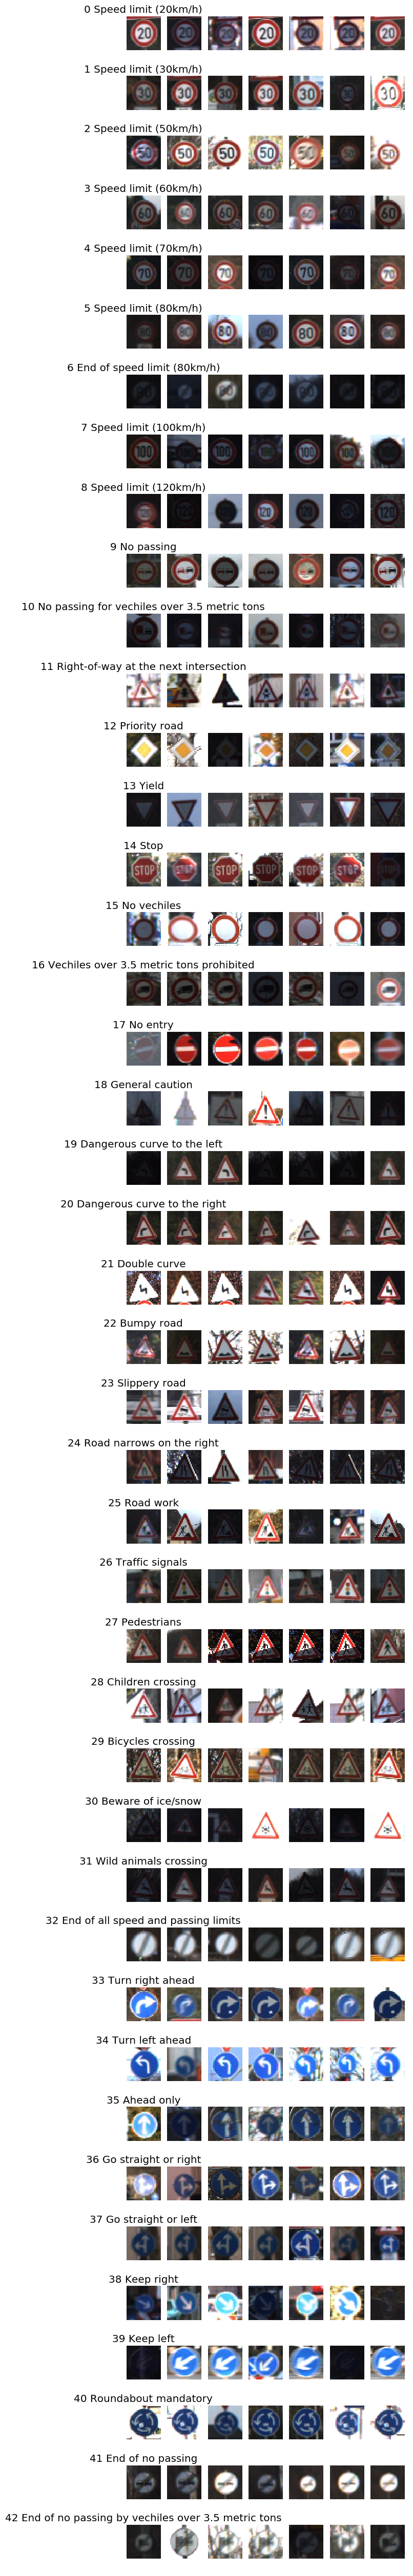

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
%matplotlib inline
examples_per_class=7
n_classes_display=43
plt.rcParams['figure.figsize'] = (examples_per_class, 1.5*n_classes_display) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size']=12

# Choice random test images to display
for cls in range(n_classes_display):
    idxs = np.where((y_test == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(n_classes_display, examples_per_class, cls * examples_per_class + i +1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if(i==0):
            plt.title(str(cls)+' '+signname[cls])

            


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

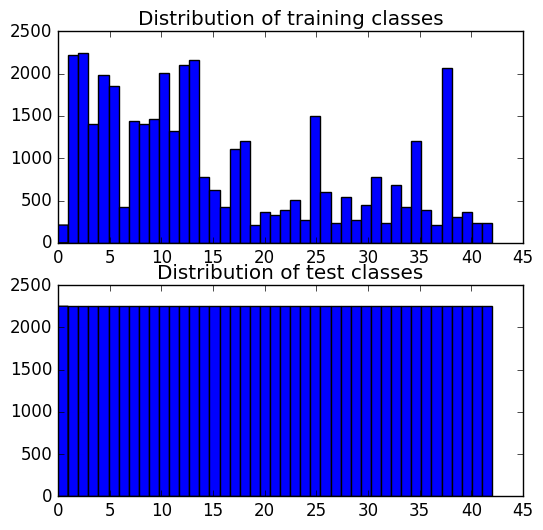

In [42]:
## Generate extra images to balance the dataset distribution among classes

# Look at distibution of classes
hist,bin_edges=np.histogram(y_train, n_classes)

# add extra samples to make the balance the distribution
extra_samples=(max(hist)-hist)
total_extra_samples=np.sum(extra_samples)
X_train_extra=np.empty((total_extra_samples,32,32,3))
y_train_extra=np.empty((total_extra_samples))
i=0
for cls in range(n_classes):
    class_samples= X_train[y_train==cls]
    #jitter_per_sample=int(math.ceil(extra_samples[cls]/float(len(class_samples))))
    #print(cls,extra_samples[cls],len(class_samples),jitter_per_sample)
    n=len(class_samples)
    for _ in range(extra_samples[cls]):
        original=class_samples[int(np.random.uniform()*n)]
        #copy=transform_image(original,10,5,5)
        copy=original
        X_train_extra[i,:,:,:]=copy#np.reshape(copy,(1,32,32,3))
        y_train_extra[i]=np.array([cls])
        i+=1

X_train_extra=np.vstack((X_train, X_train_extra))
y_train_extra=np.hstack((y_train, np.array(y_train_extra)))

# set default size of plots
plt.rcParams['figure.figsize'] = (6, 6) 
plt.rcParams['font.size']=12
plt.figure()
plt.subplot(2,1,1)
plt.hist(y_train,n_classes)
plt.title("Distribution of training classes")
plt.subplot(2,1,2)
plt.hist(y_train_extra,n_classes)
plt.title("Distribution of test classes")
plt.show()

In [7]:
# Split into training and validation set
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub=train_test_split(
X_train_extra, y_train_extra, test_size=0.1, random_state=0)

# Normalisation by subtracting mean
X_mean=np.mean(X_train_sub,axis=0,dtype=np.float64)
X_train_sub=X_train_sub.astype(np.float64)-X_mean
X_valid_sub=X_valid_sub.astype(np.float64)-X_mean
X_test=X_test.astype(np.float64)-X_mean

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
Normalisation by taking average of all training samples and extract it from all training, validation and test samples. 

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
I use sklearn.model_selection.train_test_split() to randomly split the training data into training and validation sets. The given X_train is sorted according to the labels i.e. the first k-samples are all from class id=0. If I train the network by taking minibatches of sorted data, the network will not train. Therefore it is important to randomise the dataset to activate different neurons to allow the gradients to flow in backpropagation.

On the other hand, the dataset is unbalanced with some classes have more data than others. The network would then be less 'familiar' with the classes with few data and hence produce higher prediction error. To balance the data, I employ a simple method to simply duplicate the sample images of less frequent classes to balance the distribution. I tried jittering the images but it does not work better than the simple duplication methods.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def weight_variables(shape, stddev=1e-1):
    return(tf.Variable(tf.truncated_normal(shape ,mean=0.0,stddev=stddev)))

def bias_variables(shape):
    return(tf.Variable(tf.zeros(shape)))

def conv2d(x,W,stride=1):
    return(tf.nn.conv2d(x,W,strides=[1,stride,stride,1],padding='SAME'))

def max_pool(x, ksize=2):
    return(tf.nn.max_pool(x,
                         ksize=[1,ksize,ksize,1],
                         strides=[1,ksize,ksize,1],
                         padding='SAME'))
 

In [9]:
image_size=X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
x=tf.placeholder(tf.float32,[None,image_shape[0],image_shape[1],n_channel], name="x")
y_true=tf.placeholder(tf.int64,[None],name="y_true")
keep_prob=tf.placeholder(tf.float32)
downsample=1
# Convolutional layer 1
ksize=3
n_features1=32
x_image=tf.reshape(x,[-1,image_shape[0],image_shape[1],n_channel])
W_conv1=weight_variables([ksize,ksize,n_channel,n_features1])
b_conv1=bias_variables([n_features1])
h_conv1=conv2d(x_image,W_conv1)+b_conv1
# Add batch normalisation
scale1 = tf.Variable(tf.ones([n_features1]))
beta1 = tf.Variable(tf.zeros([n_features1]))
batch_mean1, batch_var1=tf.nn.moments(h_conv1,[0])
h_conv1_bn= tf.nn.batch_normalization(h_conv1,batch_mean1,batch_var1,beta1,scale1,1e-9)

h_conv1_relu=tf.nn.relu(h_conv1_bn)
h_conv1_drop=tf.nn.dropout(h_conv1_relu,keep_prob)
h_pool1=max_pool(h_conv1_drop)

downsample*=2
# Convolutional layer 2
ksize=3
n_features2=64
W_conv2=weight_variables([ksize,ksize,n_features1,n_features2])
b_conv2=bias_variables([n_features2])
h_conv2=conv2d(h_pool1,W_conv2)+b_conv2

# Add batch normalisation
scale2 = tf.Variable(tf.ones([n_features2]))
beta2 = tf.Variable(tf.zeros([n_features2]))
batch_mean2, batch_var2=tf.nn.moments(h_conv2,[0])
h_conv2_bn= tf.nn.batch_normalization(h_conv2,batch_mean2,batch_var2,beta2,scale2,1e-9)

h_conv2_relu=tf.nn.relu(h_conv2_bn)
h_conv2_drop=tf.nn.dropout(h_conv2_relu,keep_prob)
h_pool2=max_pool(h_conv2_drop)
downsample*=2

# Fully connected layer
n_fc_neurons=1024
fc_input_dim=image_shape[0]/downsample
W_fc1=weight_variables([fc_input_dim*fc_input_dim*n_features2,n_fc_neurons])
b_fc1=bias_variables([n_fc_neurons])
h_pool2_flat=tf.reshape(h_pool2,[-1,fc_input_dim*fc_input_dim*n_features2])
h_pool_fc1=tf.matmul(h_pool2_flat,W_fc1)+b_fc1
# Add batch normalisation
scale_fc1 = tf.Variable(tf.ones([n_fc_neurons]))
beta_fc1 = tf.Variable(tf.zeros([n_fc_neurons]))
batch_mean_fc1, batch_var_fc1=tf.nn.moments(h_pool_fc1,[0])
h_fc1_bn= tf.nn.batch_normalization(h_pool_fc1,batch_mean_fc1,batch_var_fc1,beta_fc1,scale_fc1,1e-9)
h_fc1=tf.nn.relu(h_fc1_bn)
# Add dropout
h_fc1_drop=tf.nn.dropout(h_fc1,keep_prob)

# Output layer
W_fc2=weight_variables([n_fc_neurons,n_classes])
b_fc2=weight_variables([n_classes])
logits=tf.matmul(h_fc1_drop,W_fc2)+b_fc2


# define loss
cross_entropy=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,y_true))
# define training
learning_rate=tf.placeholder(tf.float32)
train_step=tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)   

### Calculate accuracy
### 
predict=tf.argmax(tf.nn.softmax(logits),1)

correct_prediction=tf.equal(predict,y_true)
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I use deep convolutional neural networks with the following layers and softmax as loss function. The input layer assumes 32x32x3 RGB images
1. Convolutional Layer (number of features=32, kernel size=3, max pool=2x2)
2. Convolutional Layer (number of features=64, kernel size=3, max pool=2x2)
3. Fully connected layer (number of column nodes=1024)
4. Fully connected layer (number of column nodes=43)

All layers use:
1. batch normalisation to speed up the training
2. dropout to reduce overfitting
3. ReLU as non-linearity


In [10]:
def plot_images(images, cls_true=None, cls_pred=None, title=None):
    #assert len(images) == len(cls_true) == 16
    plt.rcParams['figure.figsize']=(6,6)
    plt.rcParams['figure.dpi']=256
    plt.rcParams['font.size']=8
    # Create figure with 4x4 sub-plots.
    fig, axes = plt.subplots(4, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        img=images[i]
        ax.imshow(img)

        # Show true and predicted classes.
        if cls_true is None:            
            xlabel =title[i]
        elif cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [26]:
### Train your model here.
### Feel free to use as many code cells as needed.
train_acc, train_loss=[],[]
valid_acc = []
batch_size=200
learn_rate=5e-3
decay_rate=0.75
total_iterations = 0
total_epochs = 0

sess=tf.Session()
sess.run(tf.initialize_all_variables())


In [27]:
def optimize(n_epoch=1):

    global total_iterations
    global total_epochs
    global learn_rate
    global train_loss, train_acc, valid_acc
    for epoch in range(n_epoch):
        epoch_start_t=time.clock()
        
        for i in range(int(X_train_sub.shape[0]/batch_size)):
            batch_start=i*batch_size
            batch_stop=(i+1)*batch_size
            batch_x=X_train_sub[batch_start:batch_stop]
            batch_y=y_train_sub[batch_start:batch_stop]
            _,batch_loss=sess.run([train_step,cross_entropy], 
                                  feed_dict={x:batch_x, y_true:batch_y,
                                             keep_prob:0.7,
                                             learning_rate:learn_rate})
            train_loss+=[batch_loss]
            if i%100 == 0:
                t_acc=sess.run(accuracy,feed_dict={x:batch_x,y_true:batch_y, keep_prob:1.0})                
                print("Iteration %d, training accuracy=%.5f loss=%.5f"%(total_iterations,t_acc,batch_loss))                
            total_iterations+=1
            
        learn_rate*=decay_rate
        epoch_stop_t=time.clock()
        # Validation accuracy
        v_acc=sess.run(accuracy,feed_dict={x:X_valid_sub, y_true:y_valid_sub, keep_prob:1.0})
        print("Epoch %d, validation accuracy=%.5f elapsed=%.2f s"%(total_epochs,v_acc,epoch_stop_t-epoch_start_t))       
        valid_acc+=[v_acc]
        train_acc+=[t_acc]
        total_epochs+=1
        



In [38]:
# Run Training
n_epoch=1
optimize(n_epoch)   

Iteration 3607, training accuracy=1.00000 loss=0.00
Iteration 3707, training accuracy=1.00000 loss=0.00
Iteration 3807, training accuracy=1.00000 loss=0.00
Iteration 3907, training accuracy=1.00000 loss=0.00
Iteration 4007, training accuracy=1.00000 loss=0.01
Epoch 8, validation accuracy=0.99897 elapsed=1346.99 s


Validation accuracy = 0.99907
Confusion Matrix
[[220   0   0 ...,   0   0   0]
 [  0 235   0 ...,   0   0   0]
 [  0   0 239 ...,   0   0   0]
 ..., 
 [  0   0   0 ..., 201   0   0]
 [  0   0   0 ...,   0 222   0]
 [  0   0   0 ...,   0   0 216]]


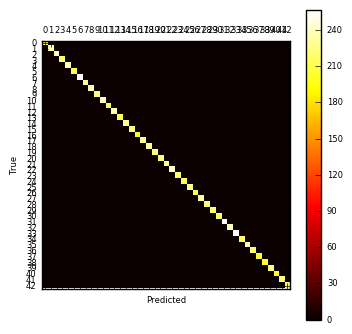

In [30]:
# Plot confusion matrix on validation data
test_acc,y_predict=sess.run([accuracy,predict],
                            feed_dict={x:X_valid_sub, y_true:y_valid_sub, 
                                       keep_prob:1.0})
print("Validation accuracy = %.5f"%(test_acc))

cm = confusion_matrix(y_true=y_valid_sub,
                      y_pred=y_predict)

print("Confusion Matrix")
print(cm)
cax=plt.matshow(cm, cmap='hot')
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, range(n_classes))
plt.yticks(tick_marks, range(n_classes))

plt.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')

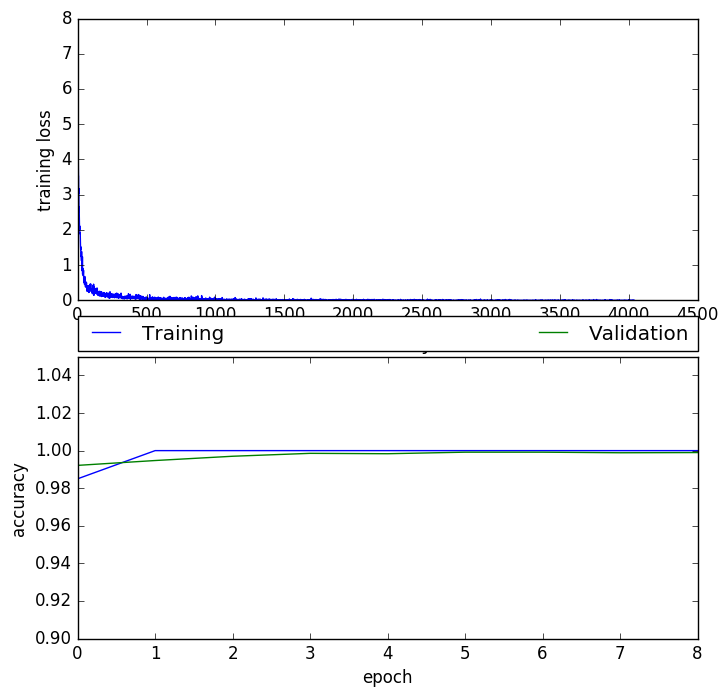

Test accuracy=0.94100


In [45]:
# Plot 
plt.figure(figsize=(8,8))
n_itr=np.arange(len(train_loss))
plt.subplot(2,1,1)
plt.plot(n_itr, train_loss)
plt.xlabel('iteration')
plt.ylabel('training loss')

epoch=np.arange(len(train_acc))
plt.subplot(2,1,2)
plt.plot(epoch, train_acc, epoch, valid_acc)
plt.ylim([0.9,1.05])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend(['Training','Validation'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

# Take subset of test dataset to get accuracy
rnd_idxs=np.random.uniform(low=0,high=X_test.shape[0],size=2000)
test_acc,y_predict=sess.run([accuracy,predict],feed_dict={x:X_test[rnd_idxs.astype(np.uint64)],
                                      y_true:y_test[rnd_idxs.astype(np.uint64)], keep_prob:1.0})
print("Test accuracy=%.5f"%(test_acc))    



### Test Accuracy

In [39]:
# Accuracy on the entire test dataset
test_acc=sess.run(accuracy,feed_dict={x:X_test,y_true:y_test, keep_prob:1.0})
print("Test accuracy=%.5f"%(test_acc))    


Test accuracy=0.93888


### Illustration
Now we try to illustrate to give some ideas of how the neural network perform

('Accuracy', 1.0)


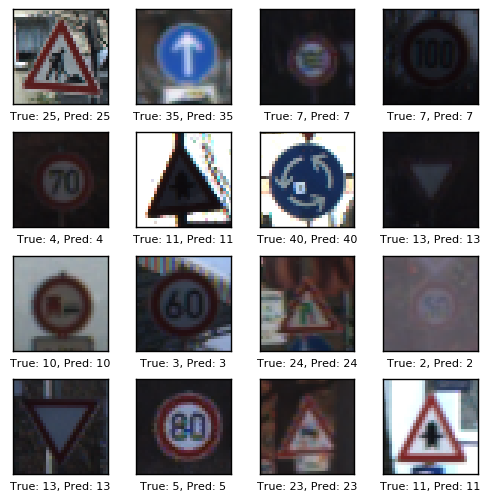

In [35]:
# Illustrate some images and predictions
a=np.random.uniform(low=0,high=X_test.shape[0],size=32)

batch_x=X_test[a.astype(np.uint64)]
batch_y=y_test[a.astype(np.uint64)]

acc, predict_labels=sess.run([accuracy,predict],feed_dict={x:batch_x,y_true:batch_y, keep_prob:1.0})
print("Accuracy",acc)

# Showing only first 16 images
img=batch_x+X_mean
plot_images(images=img.astype(np.uint8), cls_true=batch_y, cls_pred=predict_labels)

### Now we illustrate the internal of neural network

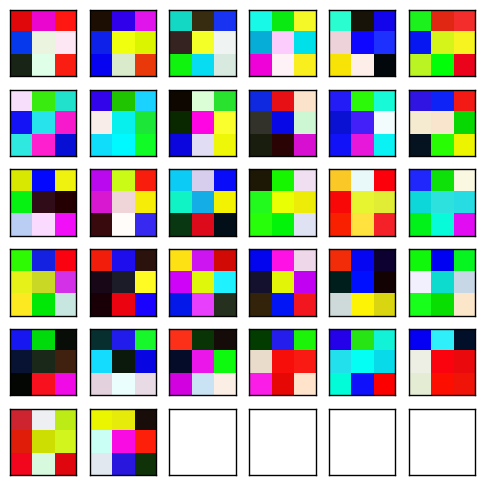

In [19]:
# Illustrate first layer convolutional layer weights
w=sess.run(W_conv1)
w_min=np.min(w)
w_max=np.max(w)
n_filters=w.shape[3]
n_grids=int(math.ceil(math.sqrt(n_filters)))

fig, axes = plt.subplots(n_grids, n_grids)
for i, ax in enumerate(axes.flat):
    if i<n_filters:
        img=w[:,:,:,i]
        ax.imshow(img,vmin=w_min,vmax=w_max,
                 interpolation='nearest',cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
  
plt.show()
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['figure.dpi']=128
plt.rcParams['font.size']=6    

### Function to plot output of convolutional layer


In [20]:
def plot_conv_layer(layer,image):
    plt.rcParams['figure.figsize']=(6,6)
    plt.rcParams['figure.dpi']=128
    plt.rcParams['font.size']=6      
    
    v=sess.run(layer, feed_dict={x:image.reshape(1,32,32,3),keep_prob:1.0})
    v_min=np.min(v)
    v_max=np.max(v)
    n_filters=v.shape[3]
    n_grids=int(math.ceil(math.sqrt(n_filters)))

    fig, axes = plt.subplots(n_grids, n_grids)
    for i, ax in enumerate(axes.flat):
        if i<n_filters:
            img=v[0,:,:,i]
            ax.imshow(img,vmin=w_min,vmax=w_max,
                     interpolation='nearest',cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()



### We can see that when feed the neural network with an image, some of the features in convolutional layer looks responds strongly to the shape of the traffic sign in the images.

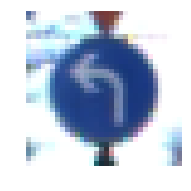

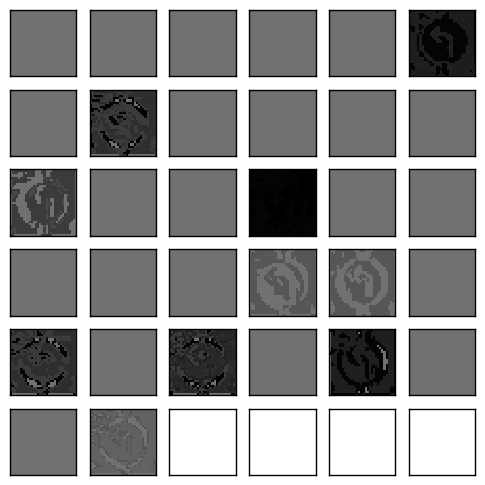

In [36]:
# Feed an input image and look at the output of convolutional layer
image=X_train_sub[12]

# input image
plt.rcParams['figure.figsize']=(2,2)
plt.rcParams['figure.dpi']=16
plt.rcParams['font.size']=6
display_image=image+X_mean
plt.imshow(display_image.astype(np.uint8))
plt.axis('off')
plt.show()

# illustrate output of convolutional layer 1
plot_conv_layer(h_conv1_relu,image)


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_




**Answer:**
I use Adam optimiser and use batch size of 200. Each training cycle is an epoch i.e. whole training set. The initial learning rate is 5e-3 and it is decayed by decay rate of 0.75 in every epoch. The higher learning rate is to speed up the training and goes down gradually to reduce the loss function. I plot the loss function against number of iterations to make sure the learning rate is okay. On the othe hand, I also plot the training and validation accuracy. If the gap between them are too high, this might suggest overfitting.

There are a number of hyperparameters including:
1. learning rate
2. decay rate
3. dropout rate
4. kernel size and number of features in convolutional layers
5. number of neurons in fully connected layers

I tried some combination of them manually and current setting achieved >99% validation accuracy in 1 epoch. With these various techniques (dropout, decay learning rate, batch normalisation etc), I could train the network quickly on CPUs instead of needing a GPU. The final test accuracy is ~94%


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
To allow for quick experiments, I encapsulate the training in function optimizer(). I can run it once, then go and look at the accuracy, do prediction on images and then go back to run the network further. I can therefore learn quicker without having to wait for the network to train from the start again.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

/space/sc15770/Code/self_driving/traffic-signs/pics/img17.jpg
/space/sc15770/Code/self_driving/traffic-signs/pics/img6.jpg
/space/sc15770/Code/self_driving/traffic-signs/pics/img1.jpg
/space/sc15770/Code/self_driving/traffic-signs/pics/img2.jpg
/space/sc15770/Code/self_driving/traffic-signs/pics/img15.jpg
/space/sc15770/Code/self_driving/traffic-signs/pics/img8.jpg
/space/sc15770/Code/self_driving/traffic-signs/pics/img9.jpg
/space/sc15770/Code/self_driving/traffic-signs/pics/img16.jpg


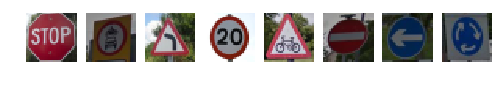

In [22]:
# Format the images into 32x32
import glob
path=os.getcwd()+'/pics'

imgsets=None
for fname in glob.glob(os.path.join(path,'img*.jpg')):
    img=cv2.imread(fname,cv2.IMREAD_COLOR)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)       
    img=cv2.resize(img,(32,32),interpolation=cv2.INTER_AREA)
    img=img.reshape((1,32,32,3))
    img=img.astype(np.float64)
    if imgsets is None:
        imgsets=np.array(img,np.float64)
    else:
        imgsets=np.vstack((imgsets,img))
    print(fname)
    i+=1
n_pics=imgsets.shape[0]

plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['figure.dpi']=128
plt.rcParams['font.size']=6    
for i in range(1,n_pics+1):
    plt.subplot(1,n_pics,i)
    plt.imshow(imgsets[i-1].astype('uint8'))
    plt.axis('off')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
There are many varations in the picture including shading and position of the sign relative to the picture. 

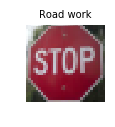

Road work	:81.43 %
Yield	:5.10 %
Stop	:5.01 %


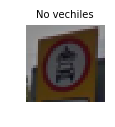

No vechiles	:99.68 %
Traffic signals	:0.15 %
General caution	:0.05 %


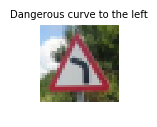

Dangerous curve to the left	:81.60 %
Road narrows on the right	:16.36 %
Pedestrians	:1.90 %


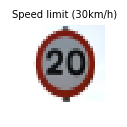

Speed limit (30km/h)	:90.48 %
Speed limit (20km/h)	:7.78 %
Speed limit (80km/h)	:1.41 %


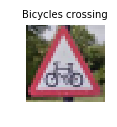

Bicycles crossing	:76.21 %
Children crossing	:14.65 %
Slippery road	:5.17 %


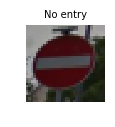

No entry	:99.97 %
Stop	:0.03 %
Beware of ice/snow	:0.00 %


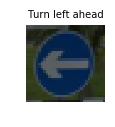

Turn left ahead	:69.57 %
Keep left	:20.84 %
Keep right	:6.11 %


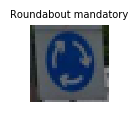

Roundabout mandatory	:59.57 %
Vechiles over 3.5 metric tons prohibited	:40.25 %
Speed limit (100km/h)	:0.11 %


In [37]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
# Normalise the dataset
norm_imgsets=imgsets-X_mean

# Predict
top_k_range=3
k=tf.placeholder(np.int32)
top_k_predict=tf.nn.top_k(tf.nn.softmax(logits), k)
predicted_class, top_k=sess.run([predict,top_k_predict],feed_dict={x:norm_imgsets, keep_prob:1.0, k:top_k_range})

plt.rcParams['figure.figsize']=(1,1)
plt.rcParams['figure.dpi']=128
plt.rcParams['font.size']=6    

for i in range(n_pics):
    plt.imshow(imgsets[i].astype('uint8'))    
    plt.axis('off')
    xlabel = signname[predicted_class[i]]
    plt.title(xlabel)
    plt.show()
    top_k_class=top_k[1][i]
    top_k_percent=top_k[0][i]
    for j in range(top_k_range):
        print(signname[top_k_class[j]]+'\t:'+"%.2f "%(100*top_k_percent[j])+'%')    



### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
In general yes but some classes are have higher rate due to unbalanced dataset. In addition, real life images have a variety of light conditions and occlusion which can make prediction even more difficult.

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
# See cell above
sess.close()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
Yes, the correct predictions are in top-5 prediction (see cell above)

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.